# Capstone Project  -  The Battle of Neighborhoods in Munich
Week 5 Assignment  - Janos Breiteneicher - June 2021


## Introduction/Business Problem

Munich is a beautiful town in Southern Germany. There are many restaurants of all kind for ca 1.5 Mio inhabitants plus many tourists. 
I like to compare the 25 different boroughs in Size, Number of restaurants, Number of hotels, ... 

The heart of Munich is the **MARIENPLATZ**, which is the center and starting point of all streets in Bavaria. Despite the fact, that Munich is famous for breweries, beer festival and beer gardens, sometimes it is called northest city of ITALY. 

The interested _audience_ might be an investor, landlord or Italian chef , who is looking for the best environment for success

*Questions:* <br>
Is the number of restaurants decreasing in the suburbs ?  <br>
Where is a good place to open a new Italian Restaurant ? <br>
What is the ratio Restaurants/Inhabitants ?



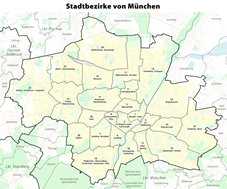

## Data Section

<ol>
    <li>First I get 25 Munich boroughs from a opengov page (www.opengov-muenchen.de).  </li>
    <li>I created a list of Neighborhoods (bezirksteile.csv).  </li>
    <li>Let's add the size, the geospatial coordinates from GeoCoder, ... </li>
    <li>Now we calculate the distance from center using the havershine algorithm</li>
    <li>In a second step the list of venues is retrieved from <b>Foursquare</b></li>
    <li>Now count the number of Hotels, Italian and other Restaurants</li>
    <li>The venues have to be assigned to the neighborhoods</li>
    <li>In a next step I will cluster Italian vs Other Restaurants</li>
</ol>
The <b>Italian Restaurants</b> cover the venue categories Pizzeria, Osteria, ...  <br> All other retaurants are aggregated.

I will create some scatter plot to show the density of restaurants per neighborhood.
Let's build a regression model to find the optimum quarter



In [2]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Data Import

### Boroughs

In [3]:
#let's define the heart of Munich
marienplatz = {'latitude':48.137222, 'longitude':11.575278}

#read the Munich city data from OpenGovernment Site
locations = pd.read_csv('https://www.opengov-muenchen.de/dataset/e3f5dbd2-39cc-40cd-bc91-4bb49a0b1802/resource/a641ce6a-4e01-4f4b-9976-1ae6a47e3762/download/jt140102.csv',header=0)

locations.drop(index=25, inplace=True)  #remove last line "nicht zuzuordnen , NaN"
locations.drop(columns=['stadtbezirk','anteil_an_gesamtbevoelkerung'], inplace=True)  #remove Stadtbezirk and percentage of total
locations.rename(columns={'einwohner':'population',
                          'flaeche':'size',
                          'einwohnerdichte':'density'}, 
                 inplace=True)

# Add a stremlined Borough List
Boroughs =['Altstadt-Lehel','Ludwigsvorstadt-Isarvorstadt','Maxvorstadt','Schwabing-West', 'Au-Haidhausen', 'Sendling', 'Sendling-Westpark','Schwanthalerhöhe', 'Neuhausen-Nymphenburg', 'München-Moosach', 'Milbertshofen-Am Hart', 'Schwabing-Freimann', 'Bogenhausen', 'Berg am Laim', 'Trudering-Riem', 'Ramersdorf-Perlach', 'Obergiesing', 'Untergiesing-Harlaching', 'Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln', 'Hadern', 'Pasing-Obermenzing', 'Aubing-Lochhausen-Langwied', 'Allach-Untermenzing', 'Feldmoching-Hasenbergl', 'Laim']
locations['Boroughs'] = Boroughs

#Reorder the columns
locations = locations[['Boroughs','population','size','density']]

#### Add Geo Coordinates and Distance to Center

In [4]:
# Add the geo location Info to the data frame
geolocator = Nominatim(user_agent="muc_explorer")

for index, row in locations.iterrows():
    location = geolocator.geocode(row['Boroughs']+', München')
    locations.loc[index, 'latitude'] = location.latitude
    locations.loc[index, 'longitude'] = location.longitude

In [5]:
#Calculate the distance in km from Central Center Marienplatz

from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

#loop all Boroughs
for index, row in locations.iterrows():
    locations.loc[index, 'distance_to_center'] = haversine(marienplatz['longitude'], marienplatz['latitude'],row['longitude'], row['latitude'])
    

locations.sort_values('distance_to_center').head()

,Boroughs,population,size,density,latitude,longitude,distance_to_center
0,Altstadt-Lehel,20422,314.57,65.0,48.137828,11.574582,0.084877
1,Ludwigsvorstadt-Isarvorstadt,50620,440.14,115.0,48.131771,11.555809,1.565809
2,Maxvorstadt,51642,429.79,120.0,48.151092,11.562418,1.812394
4,Au-Haidhausen,59752,421.96,142.0,48.130274,11.598334,1.876146
17,Untergiesing-Harlaching,51937,805.67,64.0,48.114963,11.570189,2.502145


In [6]:
locations.sort_values('distance_to_center').tail()

,Boroughs,population,size,density,latitude,longitude,distance_to_center
18,Thalkirchen-Obersendling-Forstenried-Fürstenri...,90790,1776.31,51.0,48.084213,11.508051,7.718810
20,Pasing-Obermenzing,70783,1649.78,43.0,48.152363,11.468434,8.098986
23,Feldmoching-Hasenbergl,59391,2893.78,21.0,48.218462,11.520409,9.901101
22,Allach-Untermenzing,30737,1545.17,20.0,48.195157,11.462973,10.522982
21,Aubing-Lochhausen-Langwied,42305,3406.02,12.0,48.165059,11.400221,13.342083


### 2. Neighborhoods

In [7]:
with open('Bezirksteile.xls') as bezirke:
    neighborhoods = pd.read_excel('Bezirksteile.xls')

neighborhoods.replace(to_replace="Ludwigvorstadt - Kliniken", value="Ludwigvorstadt", inplace=True)

neighborhoods.rename(columns={'Stadtbezirk':'Borough',
                          'Bezirksteil':'Neighbourhood'}, 
                 inplace=True)

print(neighborhoods.shape)
neighborhoods.head()

(108, 2)


,Borough,Neighbourhood
0,Altstadt - Lehel,Graggenau
1,Altstadt - Lehel,Angerviertel
2,Altstadt - Lehel,Hackenviertel
3,Altstadt - Lehel,Kreuzviertel
4,Altstadt - Lehel,Lehel


In [8]:
# Add the geo location Info to the data frame
geolocator = Nominatim(user_agent="muc_explorer")

for index, row in neighborhoods.iterrows():
    location = geolocator.geocode(row['Neighbourhood']+', München')
    neighborhoods.loc[index, 'latitude'] = location.latitude
    neighborhoods.loc[index, 'longitude'] = location.longitude


In [9]:
#loop all Neighborhoods
for index, row in neighborhoods.iterrows():
    neighborhoods.loc[index, 'distance_to_center'] = haversine(marienplatz['longitude'], marienplatz['latitude'],row['longitude'], row['latitude'])
    
neighborhoods.sort_values('distance_to_center').tail()

,Borough,Neighbourhood,latitude,longitude,distance_to_center
104,Feldmoching - Hasenbergl,Ludwigsfeld,48.211638,11.489946,10.410234
97,Aubing - Lochhausen - Langwied,Aubing-Süd,48.155600,11.414201,12.116562
99,Aubing - Lochhausen - Langwied,Freiham,48.140008,11.410070,12.255281
98,Aubing - Lochhausen - Langwied,Lochhausen,48.176021,11.408845,13.069573
96,Aubing - Lochhausen - Langwied,Altaubing,48.165736,11.401493,13.268056


## Create Map of Munich

In [10]:
# create map of Munich using latitude and longitude values   marienplatz = {'latitude':48.137222, 'longitude':11.575278}
map_munich = folium.Map(location=[marienplatz['latitude'], marienplatz['longitude']], zoom_start=11)

# add all markers to map
for lat, lng, label, rad in zip(locations['latitude'], locations['longitude'], locations['Boroughs'], locations['density']):
    label = folium.Popup('Borough : '+label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8*rad/145,  #size depending einwohnerdichte = density = inhabitants per area
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich)

# add all markers to map
for lat, lng, label in zip(neighborhoods['latitude'], neighborhoods['longitude'], neighborhoods['Neighbourhood']):
    label = folium.Popup('Neighbourhood: '+label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,  
        popup=label,
        color='red',
        fill=True,
        fill_color='#3116cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich)

    
#Add Marker for Marienplatz    
folium.CircleMarker(
        [48.137222, 11.575278],
        radius=2,
        popup='Marienplatz',
        color='yellow',
        fill=True,
        fill_color='#3056cf',
        fill_opacity=0.4,
        parse_html=False).add_to(map_munich) 

map_munich

Yellow Circle = Marienplatz  <br>
Blue Circle = Borough, size relative <br>
Blue Circle = Neighborhood <br>


# 2. Get Foursquare Data per Borough and Neighborhood

In [22]:
# @hidden_cell
CLIENT_ID = 'yyy' # your Foursquare ID
CLIENT_SECRET = 'xxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [31]:
radius = 300 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    marienplatz['latitude'], 
    marienplatz['longitude'], 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [32]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [33]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Marienplatz,Plaza,48.137132,11.575992
1,Fischbrunnen,Fountain,48.137211,11.576047
2,Chocolaterie Beluga,Café,48.135750,11.575776
3,Alois Dallmayr,Gourmet Shop,48.138469,11.577372
4,Kustermann,Department Store,48.136242,11.574897


In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Same function, but using a SEARCH Term

In [73]:
def getNearbyVenuesRest(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            'restaurant', #query
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
#        results = requests.get(url).json()["response"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
munich_venues = getNearbyVenues(names=locations['Boroughs'],
                                   latitudes=locations['latitude'],
                                   longitudes=locations['longitude'], 
                                radius=800
                                  )

munich_neighborhood_venues = getNearbyVenues(names=neighborhoods['Neighbourhood'],
                                   latitudes=locations['latitude'],
                                   longitudes=locations['longitude'],
                                  radius=600
                                 )

In [38]:
print('Venues found per Boroughs', munich_venues.shape)
print('Venues found per Neighbourhood', munich_neighborhood_venues.shape)
munich_neighborhood_venues.head()

Venues found per Boroughs (1134, 7)
Venues found per Neighbourhood (741, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Graggenau,48.137828,11.574582,Marienplatz,48.137132,11.575992,Plaza
1,Graggenau,48.137828,11.574582,Elly Seidl,48.139410,11.575512,Candy Store
2,Graggenau,48.137828,11.574582,Fischbrunnen,48.137211,11.576047,Fountain
3,Graggenau,48.137828,11.574582,Alois Dallmayr,48.138469,11.577372,Gourmet Shop
4,Graggenau,48.137828,11.574582,Kustermann,48.136242,11.574897,Department Store


## Cluster and Aggregate relevant data

In [39]:
# combine different categories
Italian = ['Italian Restaurant', 'Pizzeria', 'Pizza Place', 'Trattoria/Osteria']
Restaurants = ['German Restaurant', 'Indian Restaurant', 'Afghan Restaurant','Cafe','Asian Restaurant', 'Sushi Restaurant', 
               'Spanish Restaurant', 'Chinese Restaurant', 'Doner Restaurant'
              'Vietnamese Restaurant', 'Greek Restaurant', 'Turkish Restaurant', 'Bavarian Restaurant', 'Thai Restaurant', 'Japanese Restarant', 'Steakhouse' ]

munich_venues2 = munich_venues[(munich_venues['Venue Category'].isin(Restaurants)) | 
                               (munich_venues['Venue Category'].isin(Italian)) | 
                               (munich_venues['Venue Category'] == 'Hotel') ]

munich_neighborhood_venues2 = munich_neighborhood_venues[(munich_neighborhood_venues['Venue Category'].isin(Restaurants)) | 
                               (munich_neighborhood_venues['Venue Category'].isin(Italian)) | 
                               (munich_neighborhood_venues['Venue Category'] == 'Hotel') ]


print(munich_venues2.shape)
print(munich_neighborhood_venues2.shape)
munich_venues2.head()

(299, 7)
(191, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,Altstadt-Lehel,48.137828,11.574582,Andechser am Dom,48.138302,11.573778,Bavarian Restaurant
16,Altstadt-Lehel,48.137828,11.574582,Augustiner Klosterwirt,48.138649,11.572527,German Restaurant
22,Altstadt-Lehel,48.137828,11.574582,Due Passi,48.137194,11.578709,Italian Restaurant
30,Altstadt-Lehel,48.137828,11.574582,Cortiina Hotel,48.136804,11.579450,Hotel
31,Altstadt-Lehel,48.137828,11.574582,ZWICKL Gastlichkeit am Viktualienmarkt,48.135240,11.577249,German Restaurant


## 3. Analyse data

#### Prepare figures per Borough

In [40]:
#extend the location data frame with some statistic
locations2 = locations.set_index('Boroughs')
locations2['Total_venues'] = 0
locations2['Hotel'] = 0
locations2['Italian'] = 0
locations2['Other'] = 0

locations2['Total_venues'] = munich_venues.groupby(['Neighborhood']).count()
locations2['Italian'] = munich_venues2[(munich_venues2['Venue Category'].isin(Italian))].groupby(['Neighborhood']).count()
locations2['Hotel'] = munich_venues2[(munich_venues2['Venue Category']=='Hotel')].groupby(['Neighborhood']).count()
locations2['Other'] = munich_venues2[(munich_venues2['Venue Category'].isin(Restaurants))].groupby(['Neighborhood']).count()

locations2['Total_venues'] =locations2['Total_venues'].fillna(0)
locations2['Hotel'] =locations2['Hotel'].fillna(0)
locations2['Other'] =locations2['Other'].fillna(0)
locations2['Italian'] =locations2['Italian'].fillna(0)

locations2.sort_values('Italian', ascending=False).head()

,population,size,density,latitude,longitude,distance_to_center,Total_venues,Hotel,Italian,Other
Boroughs,,,,,,,,,,
Au-Haidhausen,59752,421.96,142.0,48.130274,11.598334,1.876146,100,5.0,14.0,16.0
Schwanthalerhöhe,29663,207.02,143.0,48.133782,11.541057,2.566542,82,6.0,9.0,14.0
Maxvorstadt,51642,429.79,120.0,48.151092,11.562418,1.812394,100,2.0,8.0,14.0
Neuhausen-Nymphenburg,95906,1291.45,74.0,48.154222,11.531517,3.754590,69,2.0,8.0,17.0
Schwabing-West,65892,436.30,151.0,48.168271,11.569873,3.473506,67,1.0,6.0,12.0


In [41]:
#extend the location data frame with some statistic
neighborhoods2 = neighborhoods.set_index('Neighbourhood')
neighborhoods2['Total_venues'] = 0
neighborhoods2['Hotel'] = 0
neighborhoods2['Italian'] = 0
neighborhoods2['Other'] = 0

neighborhoods2['Total_venues'] = munich_neighborhood_venues.groupby(['Neighborhood']).count()
neighborhoods2['Italian'] = munich_neighborhood_venues2[(munich_neighborhood_venues2['Venue Category'].isin(Italian))].groupby(['Neighborhood']).count()
neighborhoods2['Hotel'] = munich_neighborhood_venues2[(munich_neighborhood_venues2['Venue Category']=='Hotel')].groupby(['Neighborhood']).count()
neighborhoods2['Other'] = munich_neighborhood_venues2[(munich_neighborhood_venues2['Venue Category'].isin(Restaurants))].groupby(['Neighborhood']).count()

neighborhoods2['Total_venues'] =neighborhoods2['Total_venues'].fillna(0)
neighborhoods2['Hotel'] =neighborhoods2['Hotel'].fillna(0)
neighborhoods2['Other'] =neighborhoods2['Other'].fillna(0)
neighborhoods2['Italian'] =neighborhoods2['Italian'].fillna(0)

neighborhoods2.sort_values('Italian', ascending=False).head()

,Borough,latitude,longitude,distance_to_center,Total_venues,Hotel,Italian,Other
Neighbourhood,,,,,,,,
Lehel,Altstadt - Lehel,48.139656,11.587921,0.975821,84.0,2.0,11.0,14.0
Deutsches Museum,Ludwigsvorstadt - Isarvorstadt,48.130041,11.582909,0.978316,53.0,1.0,7.0,7.0
Glockenbach,Ludwigsvorstadt - Isarvorstadt,48.130817,11.567400,0.920825,46.0,2.0,5.0,12.0
Kreuzviertel,Altstadt - Lehel,48.139698,11.573209,0.315073,31.0,0.0,4.0,4.0
Angerviertel,Altstadt - Lehel,48.133670,11.571569,0.481096,58.0,9.0,4.0,8.0


In [42]:
neighborhoods2.sort_values('Italian', ascending=False).tail()

,Borough,latitude,longitude,distance_to_center,Total_venues,Hotel,Italian,Other
Neighbourhood,,,,,,,,
Alte Kaserne,Neuhausen - Nymphenburg,48.156058,11.548703,2.874666,0.0,0.0,0.0,0.0
St. Vinzenz,Neuhausen - Nymphenburg,48.147099,11.540946,2.772327,0.0,0.0,0.0,0.0
Oberwiesenfeld,Neuhausen - Nymphenburg,48.185998,11.547622,5.794918,0.0,0.0,0.0,0.0
Nymphenburg,Neuhausen - Nymphenburg,48.145917,11.539117,2.850184,0.0,0.0,0.0,0.0
"St. Ulrich, Laim",Laim,48.140154,11.499468,5.631281,0.0,0.0,0.0,0.0


#### Plot the Restaurant Distribution

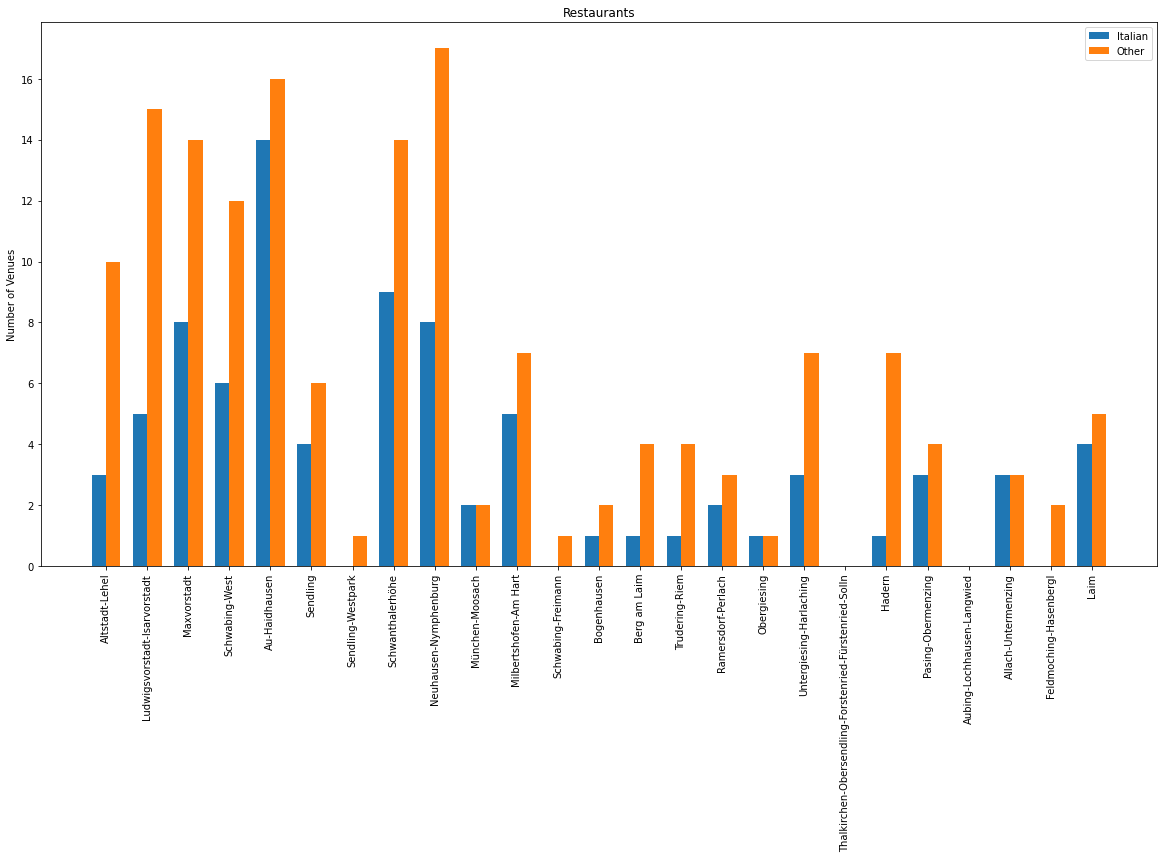

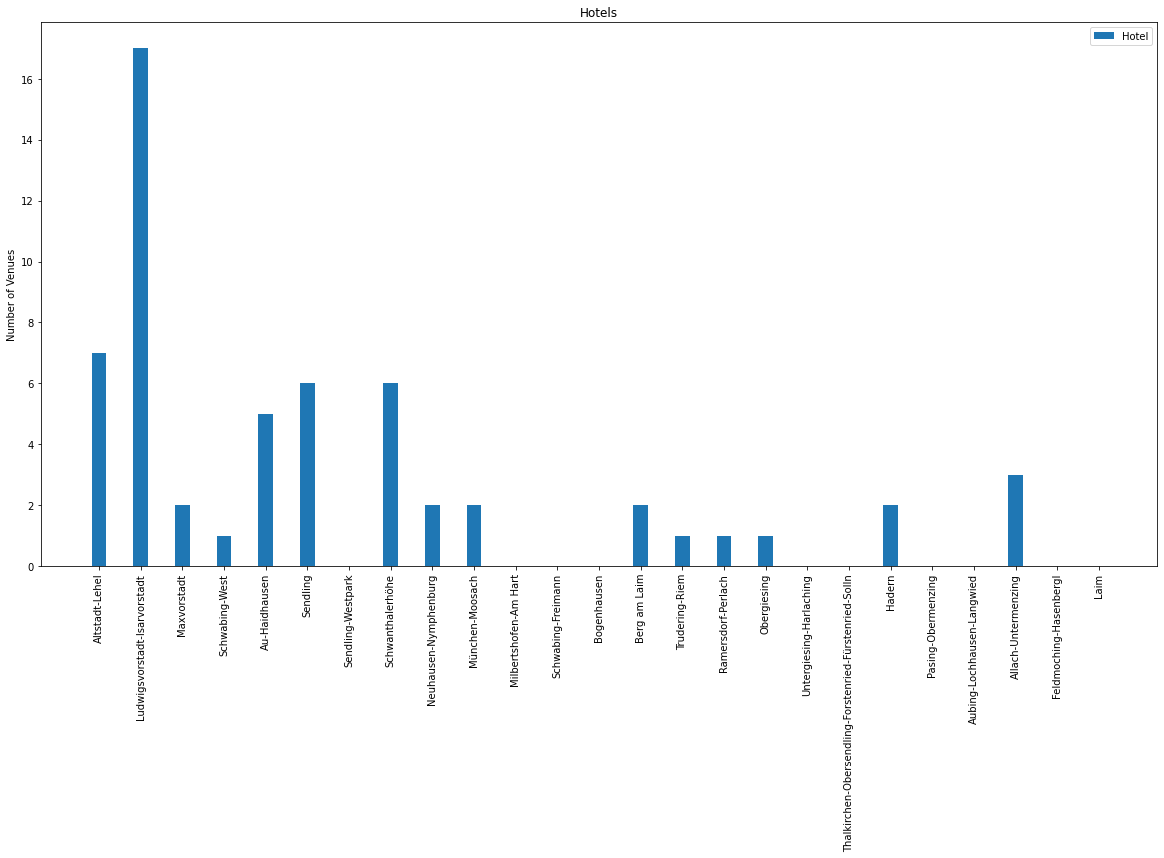

In [76]:
labels = Boroughs
hotels_num = locations2['Hotel']
italian_num = locations2['Italian']
rest_other_num = locations2['Other']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x - width/2, italian_num, width, label='Italian')
rects3 = ax.bar(x + width/2, rest_other_num, width, label='Other')

fig2, ax2 = plt.subplots()
rects1 = ax2.bar(x, hotels_num, width, label='Hotel')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Venues')
ax.set_title('Restaurants')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)

ax2.set_ylabel('Number of Venues')
ax2.set_title('Hotels')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=90)
ax.legend()

# Figure size
fig.set_figwidth(20)
fig2.set_figwidth(20)

plt.legend(loc='best')
plt.show()

#### Number of Hotels related to distance from center

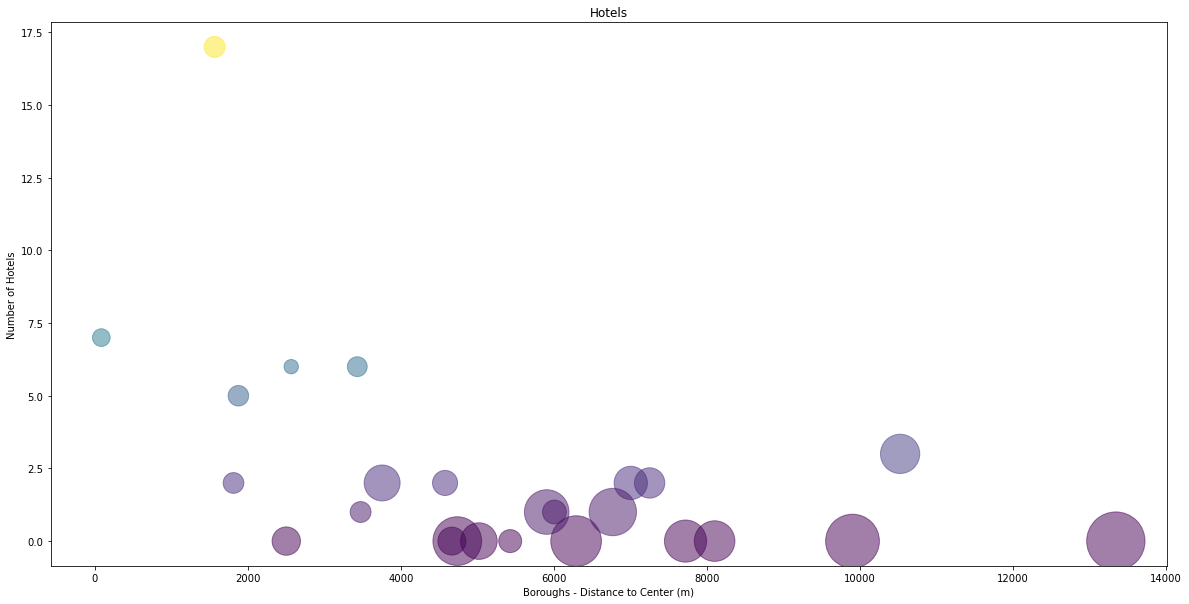

In [44]:
#set up the scatter plot
y = locations2['Hotel']
x = locations2['distance_to_center']*1000
z = locations2['size'] #size of bubble
c = locations2['Hotel']*1919 #colours
plt.rcParams['figure.figsize'] = 20, 10

plt.title('Hotels')
plt.xlabel("Boroughs - Distance to Center (m)")
plt.ylabel("Number of Hotels")
plt.scatter(x, y, s=z, c=c, alpha=0.5)

plt.show()

The downtown area has most hotels, but small density. In the remote quarters the number of hotels is low. Many <b>living areas</b> have 0 hotels.

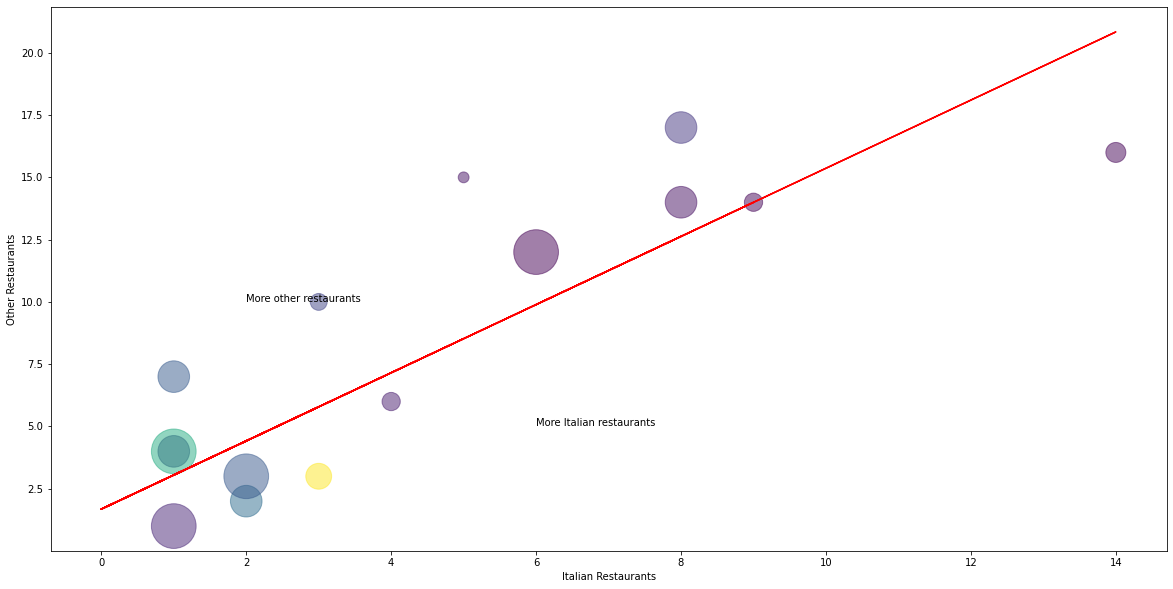

In [45]:
#set up the scatter plot
y = locations2['Other']
x = locations2['Italian']
z = 2000/locations2['Hotel'] #size of bubble
c = 90/locations2['density'] #colours
plt.rcParams['figure.figsize'] = 20, 10
fit = np.polyfit(x,y,deg=1)

plt.plot(x, fit[0] * x + fit[1], color='red') # red line
plt.xlabel("Italian Restaurants")
plt.ylabel("Other Restaurants")
plt.annotate('More other restaurants',xy=(2,10))
plt.annotate('More Italian restaurants',xy=(6,5))
plt.scatter(x, y, s=z, c=c, alpha=0.5)

plt.show()

In [ ]:
locations2.head()

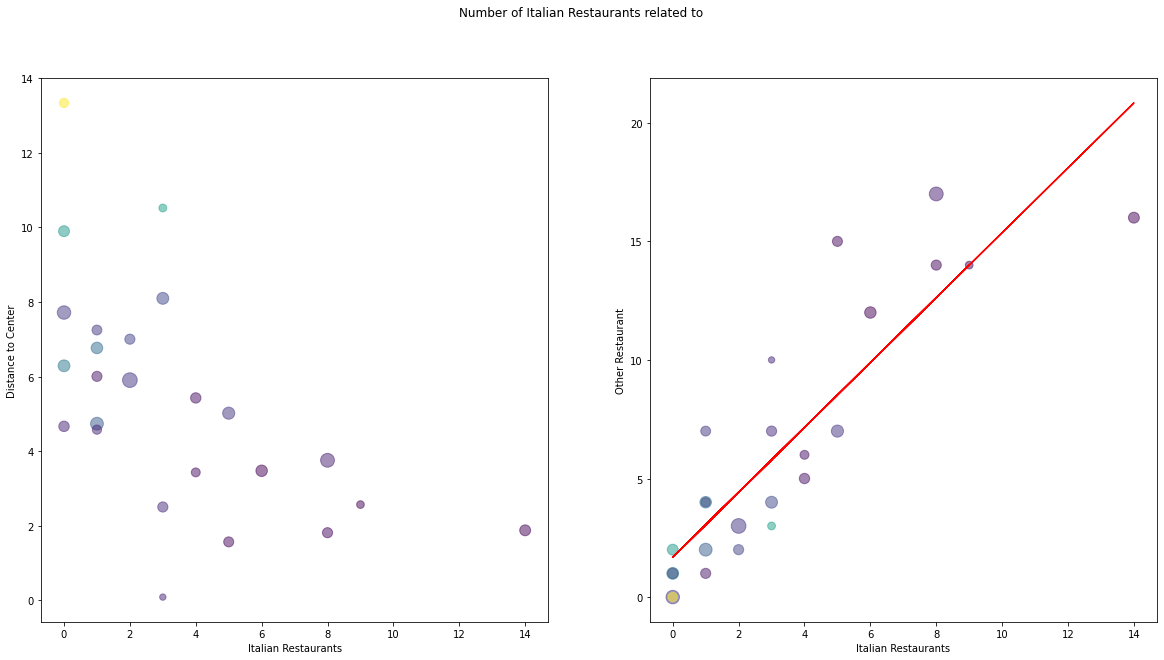

In [46]:
#set up the scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Number of Italian Restaurants related to')


y1 = locations2['distance_to_center']
y2 = locations2['Other']
x = locations2['Italian']
z = locations2['population']/500 #size of bubble
c = 90/locations2['density'] #colours
#plt.rcParams['figure.figsize'] = 0, 10
fit = np.polyfit(x,y2,deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red') # red line

#plt.xlabel("Italian Restaurants")
#plt.ylabel("Distance to Center")
#plt.scatter(x, y, s=z, c=c, alpha=0.5)
ax1.set(ylabel='Distance to Center', xlabel='Italian Restaurants')
ax2.set(ylabel='Other Restaurant', xlabel='Italian Restaurants')

#plt.annotate('More other restaurants',xy=(2,10))
#plt.annotate('More Italian restaurants',xy=(8,6))

ax1.scatter(x, y1, s=z, c=c, alpha=0.5)
ax2.scatter(x, y2, s=z, c=c, alpha=0.5)

plt.show()

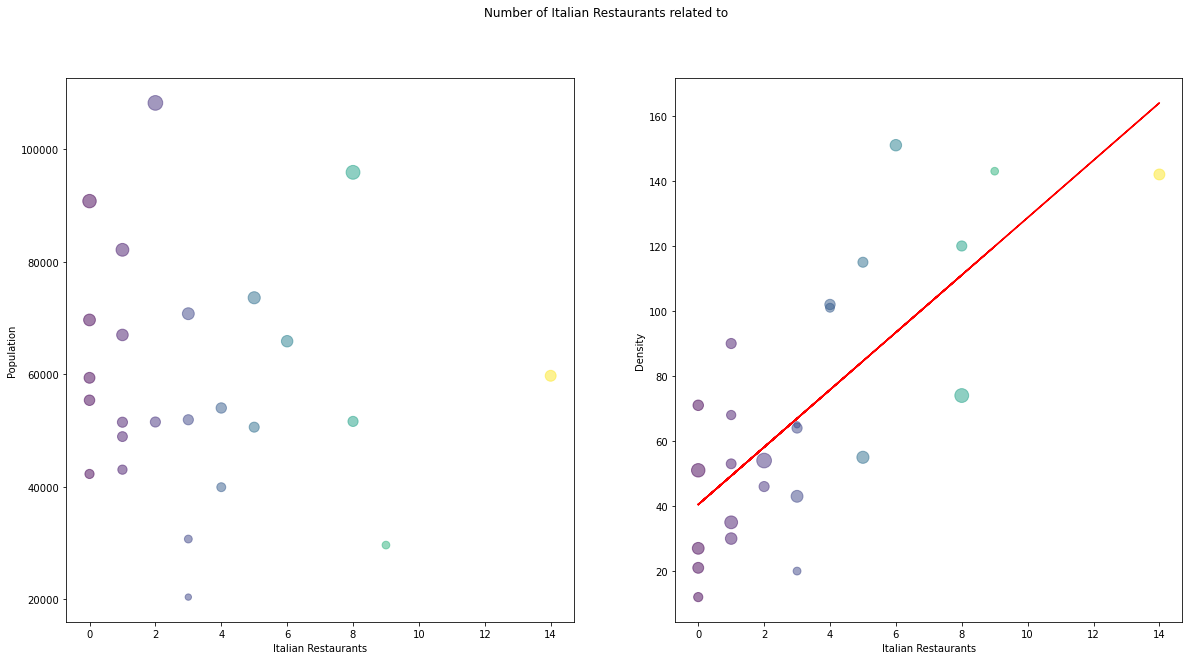

In [72]:
#set up the scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Number of Italian Restaurants related to')


y1 = locations2['population']
y2 = locations2['density']
x = locations2['Italian']
z = locations2['population']/500 #size of bubble
c = locations2['Italian'] #colours
#plt.rcParams['figure.figsize'] = 0, 10
fit = np.polyfit(x,y2,deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red') # red line

#plt.xlabel("Italian Restaurants")
#plt.ylabel("Distance to Center")
#plt.scatter(x, y, s=z, c=c, alpha=0.5)
ax1.set(ylabel='Population', xlabel='Italian Restaurants')
ax2.set(ylabel='Density', xlabel='Italian Restaurants')

ax1.scatter(x, y1, s=z, c=c, alpha=0.5)
ax2.scatter(x, y2, s=z, c=c, alpha=0.5)

plt.show()

#### Distribution per Borough

## Visualize Munich City Map

In [47]:
# create map of Munich using latitude and longitude values   marienplatz = {'latitude':48.137222, 'longitude':11.575278}
map_munich2 = folium.Map(location=[marienplatz['latitude'], marienplatz['longitude']], zoom_start=14)

# add all markers to map
for lat, lng, label, cat in zip(munich_neighborhood_venues2['Venue Latitude'], munich_neighborhood_venues2['Venue Longitude'], munich_neighborhood_venues2['Venue'], munich_neighborhood_venues2['Venue Category']):
    label = folium.Popup('Venue : '+label, parse_html=True)
    col = 'blue'
    if cat == 'Hotel':
        col = 'red'
    elif (cat == 'Italian Restaurant' or cat == 'Pizzeria'):
        col = 'green'

    folium.CircleMarker(
    [lat, lng],
    radius=3,
    popup=label,
    color=col,
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_munich2)

    
#Add Marker for Marienplatz    
folium.CircleMarker(
        [48.137222, 11.575278],
        radius=2,
        popup='Marienplatz',
        color='yellow',
        fill=True,
        fill_color='#3056cf',
        fill_opacity=0.4,
        parse_html=False).add_to(map_munich2) 

map_munich2

In [48]:
munich_neighborhood_venues.groupby(['Venue Category']).count().head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
American Restaurant,2,2,2,2,2,2
Arcade,1,1,1,1,1,1
Art Gallery,1,1,1,1,1,1
Art Museum,2,2,2,2,2,2
Arts & Crafts Store,1,1,1,1,1,1


In [49]:
# one hot encoding
munich_onehot = pd.get_dummies(munich_neighborhood_venues2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
munich_onehot['Neighborhood'] = munich_neighborhood_venues2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [munich_onehot.columns[-1]] + list(munich_onehot.columns[:-1])
munich_onehot = munich_onehot[fixed_columns]

munich_onehot.head()

,Neighborhood,Asian Restaurant,Bavarian Restaurant,Chinese Restaurant,German Restaurant,Greek Restaurant,Hotel,Indian Restaurant,Italian Restaurant,Pizza Place,Spanish Restaurant,Steakhouse,Sushi Restaurant,Thai Restaurant,Trattoria/Osteria,Turkish Restaurant
9,Graggenau,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12,Graggenau,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
19,Graggenau,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
28,Graggenau,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
30,Graggenau,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [50]:
munich_grouped = munich_onehot.groupby('Neighborhood').mean().reset_index()
munich_grouped.head()

,Neighborhood,Asian Restaurant,Bavarian Restaurant,Chinese Restaurant,German Restaurant,Greek Restaurant,Hotel,Indian Restaurant,Italian Restaurant,Pizza Place,Spanish Restaurant,Steakhouse,Sushi Restaurant,Thai Restaurant,Trattoria/Osteria,Turkish Restaurant
0,Am Luitpoldpark,0.000000,0.0,0.200000,0.000000,0.400000,0.000000,0.0,0.000000,0.2,0.000000,0.0,0.000000,0.000000,0.20,0.000000
1,Am Schlachthof,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000
2,Am alten nördlichen Friedhof,0.000000,0.0,0.000000,0.250000,0.000000,0.250000,0.0,0.000000,0.0,0.000000,0.0,0.250000,0.000000,0.25,0.000000
3,Am alten südlichen Friedhof,0.000000,0.0,0.000000,0.142857,0.285714,0.000000,0.0,0.285714,0.0,0.000000,0.0,0.000000,0.142857,0.00,0.142857
4,Angerviertel,0.047619,0.0,0.047619,0.142857,0.000000,0.428571,0.0,0.190476,0.0,0.047619,0.0,0.047619,0.047619,0.00,0.000000


In [51]:
num_top_venues = 3

for hood in munich_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = munich_grouped[munich_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Am Luitpoldpark----
                venue  freq
0    Greek Restaurant   0.4
1  Chinese Restaurant   0.2
2         Pizza Place   0.2


----Am Schlachthof----
                 venue  freq
0     Greek Restaurant   1.0
1     Asian Restaurant   0.0
2  Bavarian Restaurant   0.0


----Am alten nördlichen Friedhof----
               venue  freq
0  German Restaurant  0.25
1              Hotel  0.25
2   Sushi Restaurant  0.25


----Am alten südlichen Friedhof----
                venue  freq
0    Greek Restaurant  0.29
1  Italian Restaurant  0.29
2   German Restaurant  0.14


----Angerviertel----
                venue  freq
0               Hotel  0.43
1  Italian Restaurant  0.19
2   German Restaurant  0.14


----Augustenstraße----
                venue  freq
0   German Restaurant   0.6
1               Hotel   0.2
2  Italian Restaurant   0.2


----Deutsches Museum----
                venue  freq
0  Italian Restaurant  0.20
1         Pizza Place  0.20
2    Asian Restaurant  0.13


----Dreimühle

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = munich_grouped['Neighborhood']

for ind in np.arange(munich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(munich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Am Luitpoldpark,Greek Restaurant,Trattoria/Osteria,Pizza Place,Chinese Restaurant,Turkish Restaurant
1,Am Schlachthof,Greek Restaurant,Turkish Restaurant,Trattoria/Osteria,Thai Restaurant,Sushi Restaurant
2,Am alten nördlichen Friedhof,Trattoria/Osteria,Sushi Restaurant,Hotel,German Restaurant,Turkish Restaurant
3,Am alten südlichen Friedhof,Italian Restaurant,Greek Restaurant,Turkish Restaurant,Thai Restaurant,German Restaurant
4,Angerviertel,Hotel,Italian Restaurant,German Restaurant,Thai Restaurant,Sushi Restaurant


In [60]:
# set number of clusters
kclusters = 7

munich_grouped_clustering = munich_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(munich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 6, 5, 2, 6, 0, 2, 2, 0], dtype=int32)

In [55]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

munich_merged = neighborhoods.reset_index(drop=True) #[neighborhoods['Borough'] == 'Altstadt-Lehel'].reset_index(drop=True)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
munich_merged = munich_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

munich_merged['Cluster Labels'] = munich_merged['Cluster Labels'].fillna(5)

munich_merged.head() # check the last columns!

,Borough,Neighbourhood,latitude,longitude,distance_to_center,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Altstadt - Lehel,Graggenau,48.139168,11.581965,0.540991,2.0,Hotel,German Restaurant,Bavarian Restaurant,Steakhouse,Italian Restaurant
1,Altstadt - Lehel,Angerviertel,48.133670,11.571569,0.481096,2.0,Hotel,Italian Restaurant,German Restaurant,Thai Restaurant,Sushi Restaurant
2,Altstadt - Lehel,Hackenviertel,48.135731,11.569955,0.428105,0.0,Steakhouse,Indian Restaurant,German Restaurant,Sushi Restaurant,Italian Restaurant
3,Altstadt - Lehel,Kreuzviertel,48.139698,11.573209,0.315073,5.0,Italian Restaurant,Thai Restaurant,Spanish Restaurant,Pizza Place,Greek Restaurant
4,Altstadt - Lehel,Lehel,48.139656,11.587921,0.975821,0.0,Italian Restaurant,German Restaurant,Turkish Restaurant,Thai Restaurant,Indian Restaurant


In [56]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Am Luitpoldpark,Greek Restaurant,Trattoria/Osteria,Pizza Place,Chinese Restaurant,Turkish Restaurant
1,4,Am Schlachthof,Greek Restaurant,Turkish Restaurant,Trattoria/Osteria,Thai Restaurant,Sushi Restaurant
2,6,Am alten nördlichen Friedhof,Trattoria/Osteria,Sushi Restaurant,Hotel,German Restaurant,Turkish Restaurant
3,5,Am alten südlichen Friedhof,Italian Restaurant,Greek Restaurant,Turkish Restaurant,Thai Restaurant,German Restaurant
4,2,Angerviertel,Hotel,Italian Restaurant,German Restaurant,Thai Restaurant,Sushi Restaurant


In [57]:
neighborhoods_venues_sorted.drop(columns='Cluster Labels', inplace=True)
#munich_merged.drop(columns='Cluster Labels', inplace=True)

In [61]:
# create map
map_clusters = folium.Map(location=[marienplatz['latitude'], marienplatz['longitude']], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster1 in zip(munich_merged['latitude'], munich_merged['longitude'], munich_merged['Neighbourhood'], munich_merged['Cluster Labels']):
    cluster =int(cluster1)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [64]:
munich_merged.loc[munich_merged['Cluster Labels'] == 4, munich_merged.columns[[1] + list(range(5, munich_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Am Schlachthof,4.0,Greek Restaurant,Turkish Restaurant,Trattoria/Osteria,Thai Restaurant,Sushi Restaurant
23,Neuschwabing,4.0,Greek Restaurant,Turkish Restaurant,Trattoria/Osteria,Thai Restaurant,Sushi Restaurant


In [69]:
munich_merged.loc[munich_merged['Cluster Labels'] == 0, munich_merged.columns[[1] + list(range(5, munich_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Hackenviertel,0.0,Steakhouse,Indian Restaurant,German Restaurant,Sushi Restaurant,Italian Restaurant
4,Lehel,0.0,Italian Restaurant,German Restaurant,Turkish Restaurant,Thai Restaurant,Indian Restaurant
7,Deutsches Museum,0.0,Pizza Place,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Trattoria/Osteria
8,Glockenbach,0.0,Italian Restaurant,Indian Restaurant,Pizza Place,Hotel,German Restaurant
17,Marsfeld,0.0,German Restaurant,Pizza Place,Italian Restaurant,Greek Restaurant,Turkish Restaurant
22,Maßmannbergl,0.0,Bavarian Restaurant,Trattoria/Osteria,Italian Restaurant,Hotel,Turkish Restaurant


## 4. Conclusions